In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=50, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): 

In [9]:
loader = torch.load('gaia_train.pt')

## Inference

In [10]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.append(true)
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
    mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    ts.append(t)
    z_u, z_std = model.encoder_z0.forward(x, t)
    rec = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t)
    recs.append(rec[0])
#     z_u = z_u.squeeze()
#     z_u = z_u.detach().cpu().numpy()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


In [11]:
z_us = torch.cat(z_us,1).squeeze()
z_stds = torch.cat(z_stds,1).squeeze()
truths = torch.cat(truths,0).squeeze()

In [12]:
ts[0]

tensor([2209.8501, 2209.9299, 2210.1001, 2210.1799, 2210.3501, 2210.4299,
        2210.6001, 2210.6799, 2210.8501, 2210.9299, 2211.1001, 2211.1799,
        2211.3501, 2211.4299, 2211.6001, 2211.6799, 2211.8501, 2211.9299,
        2212.1001, 2212.1799, 2212.3501, 2212.4299, 2212.6001, 2212.6799,
        2212.8501, 2212.9299, 2213.1001, 2213.1799, 2213.3501, 2213.3601,
        2213.4299, 2213.6001, 2213.6101, 2213.6799, 2213.8501, 2213.8601,
        2213.9299, 2214.1001, 2214.1101, 2214.1799, 2214.3501, 2214.3601,
        2214.4299, 2214.6001, 2214.6101, 2214.6799, 2214.8501, 2214.8601,
        2214.9299, 2215.1001, 2215.1101, 2215.1799, 2215.3501, 2215.3601,
        2215.4299, 2215.6001, 2215.6101, 2215.6799, 2215.8501, 2215.8601,
        2215.9299, 2216.1001, 2216.1101, 2216.1799, 2216.1899, 2216.3501,
        2216.3601, 2216.4299, 2216.4399, 2216.6001, 2216.6101, 2216.6799,
        2216.6899, 2216.8501, 2216.8601, 2216.9299, 2216.9399, 2217.1001,
        2217.1101, 2217.1799, 2217.189

In [13]:
truths.shape

torch.Size([90, 329])

In [14]:
recs = torch.cat(recs,1).squeeze()

In [15]:
recs.shape

torch.Size([90, 329])

In [16]:
z_us.shape, z_stds.shape, truths.shape

(torch.Size([90, 30]), torch.Size([90, 30]), torch.Size([90, 329]))

In [17]:
ix = 88

In [18]:
u = z_us[ix]
std = z_stds[ix]

In [19]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 1)
    out = model.decoder(sol_y)
    return out

In [20]:
recs = recs.squeeze()

In [21]:
recs[ix].squeeze().shape

torch.Size([329])

In [22]:
recs[ix]

tensor([-1.7681, -1.7450, -1.6993, -1.6792, -1.6384, -1.6200, -1.5818, -1.5642,
        -1.5272, -1.5100, -1.4736, -1.4564, -1.4200, -1.4031, -1.3675, -1.3513,
        -1.3186, -1.3045, -1.2774, -1.2661, -1.2445, -1.2353, -1.2174, -1.2097,
        -1.1943, -1.1875, -1.1738, -1.1676, -1.1550, -1.1543, -1.1493, -1.1377,
        -1.1370, -1.1325, -1.1220, -1.1214, -1.1171, -1.1069, -1.1063, -1.1020,
        -1.0915, -1.0908, -1.0864, -1.0751, -1.0744, -1.0695, -1.0572, -1.0565,
        -1.0512, -1.0377, -1.0368, -1.0311, -1.0164, -1.0155, -1.0093, -0.9938,
        -0.9928, -0.9863, -0.9701, -0.9692, -0.9625, -0.9458, -0.9448, -0.9379,
        -0.9369, -0.9209, -0.9199, -0.9128, -0.9118, -0.8954, -0.8943, -0.8871,
        -0.8861, -0.8693, -0.8683, -0.8609, -0.8598, -0.8426, -0.8416, -0.8340,
        -0.8329, -0.8152, -0.8141, -0.8062, -0.8051, -0.7867, -0.7855, -0.7773,
        -0.7761, -0.7568, -0.7556, -0.7469, -0.7457, -0.7252, -0.7239, -0.7146,
        -0.7133, -0.6913, -0.6899, -0.67

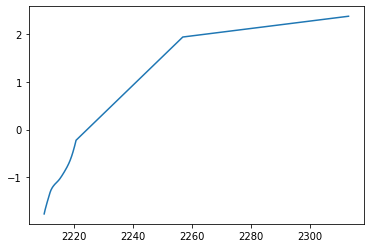

In [40]:
# sns.lineplot(x=ts[0][:100], y=recs[ix][:100].squeeze().detach().cpu().numpy())
sns.lineplot(x=ts[0], y=recs[ix].squeeze().detach().cpu().numpy())

In [24]:
truths.shape

torch.Size([90, 329])

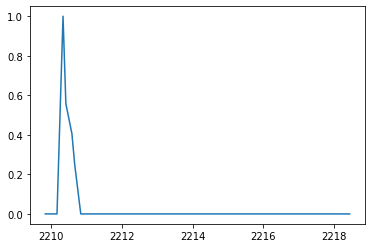

In [25]:
# sns.lineplot(x=ts[0][:100], y=truths[ix][:100].squeeze().detach().cpu().numpy())
sns.lineplot(x=ts[0], y=truths[ix].squeeze().detach().cpu().numpy())

### TSNE

In [26]:
from sklearn.manifold import TSNE

In [27]:
z_us.shape

torch.Size([90, 30])

In [28]:
latents = z_us.squeeze().detach().cpu().numpy()

In [29]:
latents.shape

(90, 30)

In [30]:
tsne = TSNE(perplexity=10)

In [31]:
xx = tsne.fit_transform(latents)

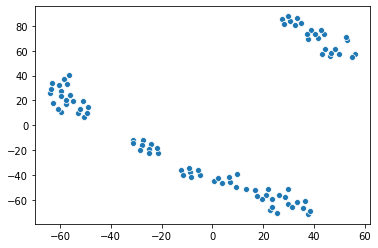

In [32]:
sns.scatterplot(x=xx[:,0], y=xx[:,1])

In [33]:
df = pd.DataFrame(xx, columns=['x1','x2'])
df['minimums'] = [np.round(x.min().item(),2) for x in truths]

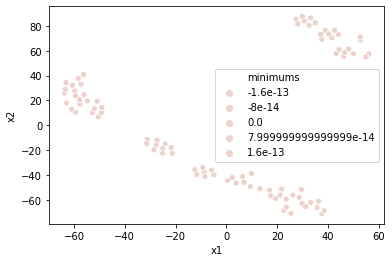

In [34]:
sns.scatterplot(x='x1', y='x2', data=df, hue='minimums')

In [35]:
g=df.loc[(df['x1']<-100) & (df['x2']<-100)]
g=df.loc[(df['x1']>0) & (df['x2']>100)]

In [36]:
gx = g.index

In [37]:
len(truths)

90

In [38]:
ls=truths[gx]

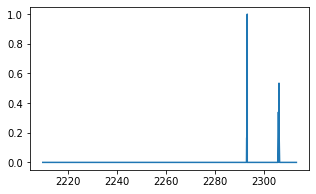

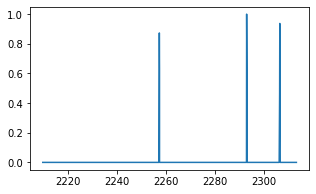

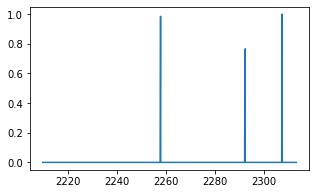

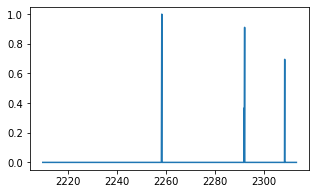

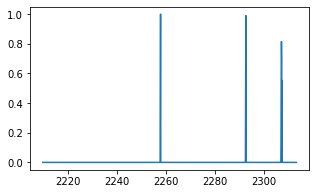

IndexError: list index out of range

<Figure size 360x216 with 0 Axes>

In [39]:
for i, p in enumerate(truths):
    x = p.detach().cpu().squeeze().numpy()
    plt.figure(figsize=(5,3))
    sns.lineplot(x=ts[i], y=x)
    plt.show()